# Kaggle Two Sigma Financial Modeling Challenge - Benchmark Models
- https://www.kaggle.com/c/two-sigma-financial-modeling/

In this notebook we build up a hopefully ever improving set of benchmark models to beat, with the following results:

<table><tr><td><b>Benchmark</td><td><b>Public LB</td><td><b>Private LB</td><td><b>Train</td>
<td><b>Public Score</td><td><b>Private Score</td><td><b>Notes</td></tr>

<tr><td>Zero</td><td></td><td></td><td>-0.008346</td><td></td><td></td><td></td></tr>
<tr><td>Mean</td><td></td><td></td><td>-0.002816</td><td></td><td></td><td></td></tr>
<tr><td>Median</td><td></td><td></td><td>-0.008643</td><td></td><td></td><td></td></tr>
<tr><td>Mean_90</td><td></td><td></td><td>-0.002760</td><td></td><td></td><td>Mean of the last 90 days</td></tr>
<tr><td>Mean_id</td><td></td><td></td><td>-0.035421</td><td></td><td></td><td>Mean per stock</td></tr>
<tr><td>Ridge</td><td></td><td></td><td>0.020538</td><td></td><td></td><td>A basic Ridge Regression</td></tr>
</table>

## Model Evaluation
- https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/am-i-over-fitting
- R: https://www.kaggle.com/dremovd/two-sigma-financial-modeling/synthetic-experiment-of-r-score-behaviour

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import kagglegym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge
import math

In [3]:
# settings 
# plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12.0, 6.0)
# pd.set_option('display.max_rows', 110)
# pd.set_option('display.max_columns', 50)

In [4]:
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
# settings 
#%logstop
#%logstart  -o '2s_models.log' rotate

In [6]:
import datetime
start = datetime.datetime.now()
print(start)

2017-03-18 16:07:15.166432


In [7]:
full_train = pd.HDFStore("../input/train.h5", "r").get("train")

In [8]:
train_p = full_train.set_index(['id','timestamp'])
train_p = train_p.to_panel()
train_p = train_p.transpose(1,2,0)
train_p

<class 'pandas.core.panel.Panel'>
Dimensions: 1424 (items) x 1813 (major_axis) x 109 (minor_axis)
Items axis: 0 to 2158
Major_axis axis: 0 to 1812
Minor_axis axis: derived_0 to y

In [17]:
# A custom function to compute the R score
from sklearn.metrics import r2_score
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    return r

In [11]:
def plot_rewards(reward_list, overall_reward_list, ts_list, market=None, full=True, title="Overall R", figsize=(10, 4)):
    fig = plt.figure(figsize=figsize)
    percent_positive = "{0:.2f}%".format((sum([x > 0 for x in reward_list])/len(reward_list)*100))
    overall_percent_positive = "{0:.2f}%".format((sum([x > 0 for x in overall_reward_list])/len(overall_reward_list))*100)
    overall_R = "{0:.4f}".format(overall_reward_list[-1])
    reward_line = pd.Series(reward_list, index=ts_list)
    overall_reward_line = pd.Series(overall_reward_list, index=ts_list)
    # ax = overall_reward_line.plot(lw=1, c='blue', label='overall R>0 = '+overall_percent_positive, legend=True)
    ax = plt.plot(ts_list, [0]*len(ts_list), c='orange')
    if full:
        if market != None:
            ax = market.cumsum().plot(c='r', lw=1, label='market mean', legend=True)
        ax = reward_line.plot(lw=0.5, c='grey', alpha=0.5, label='R>0 = '+percent_positive, legend=True)
        ax = reward_line.rolling(center=False,window=10).mean().plot(lw=0.5, c='black', alpha=1, label='rolling mean of R', legend=True)
    ax = overall_reward_line.plot(lw=1, c='b', label='overall R = '+overall_R, legend=True)
    plt.title(title)
    plt.show()

In [46]:
def plot_rewards(reward_list, overall_reward_list, ts_list, market=None, full=True, title="Overall R"):
    fig = plt.figure(figsize=(12, 6))
    percent_positive = "{0:.2f}%".format((sum([x > 0 for x in reward_list])/len(reward_list)*100))
    overall_percent_positive = "{0:.2f}%".format((sum([x > 0 for x in overall_reward_list])/len(overall_reward_list))*100)
    overall_R = "{0:.6f}".format(overall_reward_list[-1])
    reward_line = pd.Series(reward_list, index=ts_list)
    overall_reward_line = pd.Series(overall_reward_list, index=ts_list)
    # ax = overall_reward_line.plot(lw=1, c='blue', label='overall R>0 = '+overall_percent_positive, legend=True)
    ax = plt.plot(ts_list, [0]*len(ts_list), c='orange')
    if full:
        if market.any():
            ax = market.cumsum().plot(c='r', lw=1, label='market mean', legend=True)
        ax = reward_line.plot(lw=0.5, c='grey', alpha=0.5, label='R>0 = '+percent_positive, legend=True)
        ax = reward_line.rolling(center=False,window=10).mean().plot(lw=0.5, c='black', alpha=1, label='rolling mean of R', legend=True)
    ax = overall_reward_line.plot(lw=1, c='b', label='overall R = '+overall_R, legend=True)
    plt.title(title)
    plt.show()

In [30]:
import math

class Performance(object):
    
    def __init__(self, title='Model'):
        self.title = title
        self.y_actual_list = []
        self.y_pred_list = []
        self.reward_list = []
        self.overall_reward_list = []
        self.ts_list = []

    def update(self, timestamp, pred_y, reward=None):
        actual_y = list(full_train[full_train.timestamp == timestamp]["y"].values)
        self.y_actual_list.extend(actual_y)
        self.y_pred_list.extend(pred_y)
        if reward == None:
            reward = r_score(actual_y, pred_y)
        self.reward_list.append(reward)
        overall_reward = r_score(self.y_actual_list, self.y_pred_list)
        self.overall_reward_list.append(overall_reward)
        self.ts_list.append(timestamp)

    def plot(self, market=test_market, full=True):
        plot_rewards(self.reward_list, self.overall_reward_list, self.ts_list, market, full, title=self.title)
        
    def to_series(self):
        s = pd.Series(self.overall_reward_list, index=self.ts_list)
        s.name = self.title
        return s
        

In [14]:
# Train Test split
test_size = 0.50
end_train = round(len(full_train.timestamp.unique())*test_size)
x_train = full_train[full_train.timestamp <= end_train]
x_test = full_train[full_train.timestamp > end_train]

In [15]:
# Keep track of market mean
train_market = x_train.groupby('timestamp').y.mean()
test_market = x_test.groupby('timestamp').y.mean()

## All Zeros benchmark

In [32]:
# All Zeros benchmark
# Train: -0.0083462397338969572
# LB: -0.0067216 
#

env = kagglegym.make()
observation = env.reset()

zero_bench = Performance('Zero Benchmark')
done = False
while not done:
    target = observation.target
    ts = observation.features["timestamp"][0]
    observation, reward, done, info = env.step(target)
    zero_bench.update(ts, target.y, reward)
    
    if ts % 100 == 0:
        print(ts, reward)
        
print(info)

1000 -0.00976825191325
1100 -0.0784853442042
1200 -0.0672214055371
1300 -0.0383147577858
1400 -0.168415771708
1500 -0.163375270214
1600 -0.169007769424
1700 -0.0256692115081
1800 -0.054221450329
{'public_score': -0.0083462397338969572}


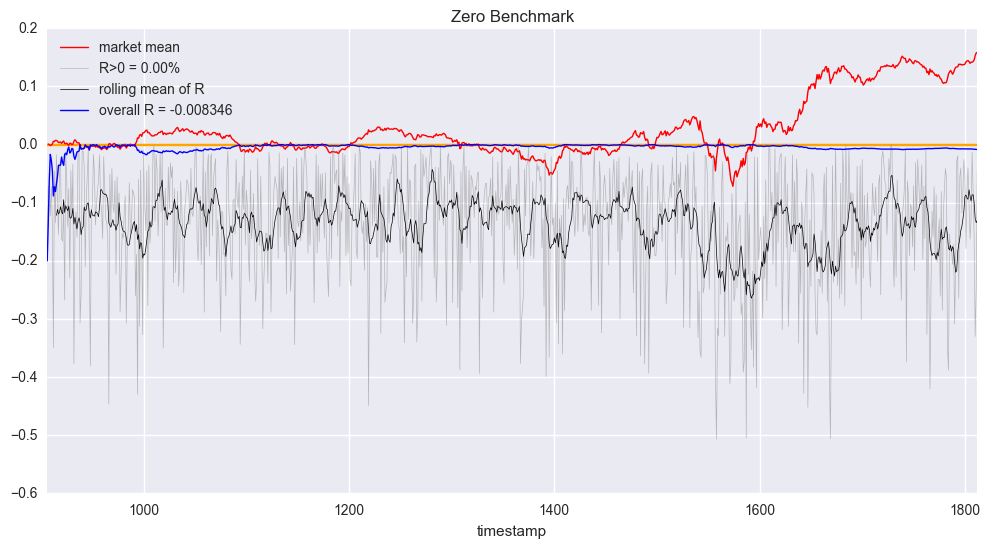

In [50]:
zero_bench.plot()

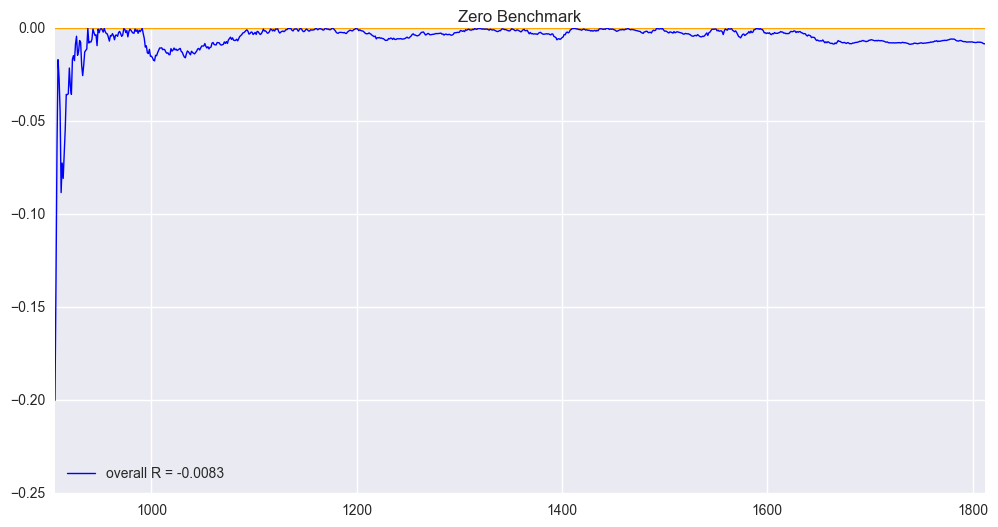

In [36]:
zero_bench.plot(full=False)

## Mean in Train Benchmark

In [38]:
# Mean for all time in train Benchmark
# Train: -0.0028160628722333015
# LB: 
#

env = kagglegym.make()
obs = env.reset()
mean_all = np.float32(obs.train.y.mean())

mean_bench = Performance('Mean Benchmark')
done = False
while not done:
    ts = obs.features.timestamp[0]
    obs.target.y = mean_all
    target_y = obs.target.y 
    target = obs.target
    obs, reward, done, info = env.step(obs.target)
    mean_bench.update(ts, target_y, reward)
    if not ts % 100:
        print(ts,reward)

print(info)

1000 -0.00390859421626
1100 -0.0651948669544
1200 -0.0840931615572
1300 -0.0523231458743
1400 -0.158905832432
1500 -0.156644648356
1600 -0.178002442723
1700 -0.0138179173154
1800 -0.0422227124896
{'public_score': -0.0028160628722333015}


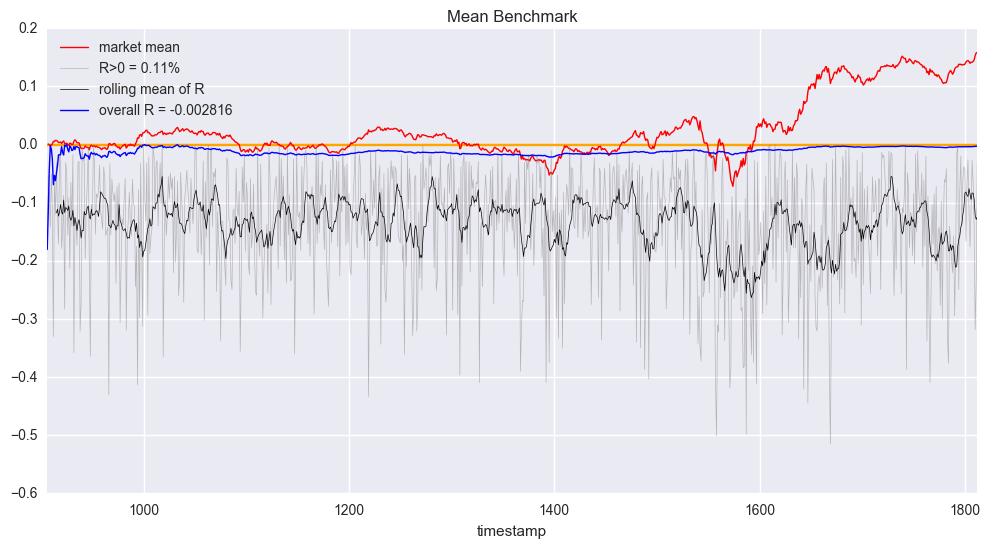

In [49]:
mean_bench.plot()

## Median in train Benchmark

In [41]:
# Median for all time in train Benchmark
#
env = kagglegym.make()
obs = env.reset()
median_all = np.float32(obs.train.y.median())

median_bench = Performance('Median Benchmark')
done = False
while not done:
    ts = obs.features.timestamp[0]
    obs.target.y = median_all
    target_y = obs.target.y
    obs, reward, done, info = env.step(obs.target)
    median_bench.update(ts, target_y, reward)
    if not ts % 100:
        print(ts,reward)
        
print(info)

1000 -0.0101320646943
1100 -0.0788390181077
1200 -0.0667725029887
1300 -0.0379419682979
1400 -0.168668839085
1500 -0.163554369608
1600 -0.168768401985
1700 -0.025984778998
1800 -0.0545408844239
{'public_score': -0.0086432744566413994}


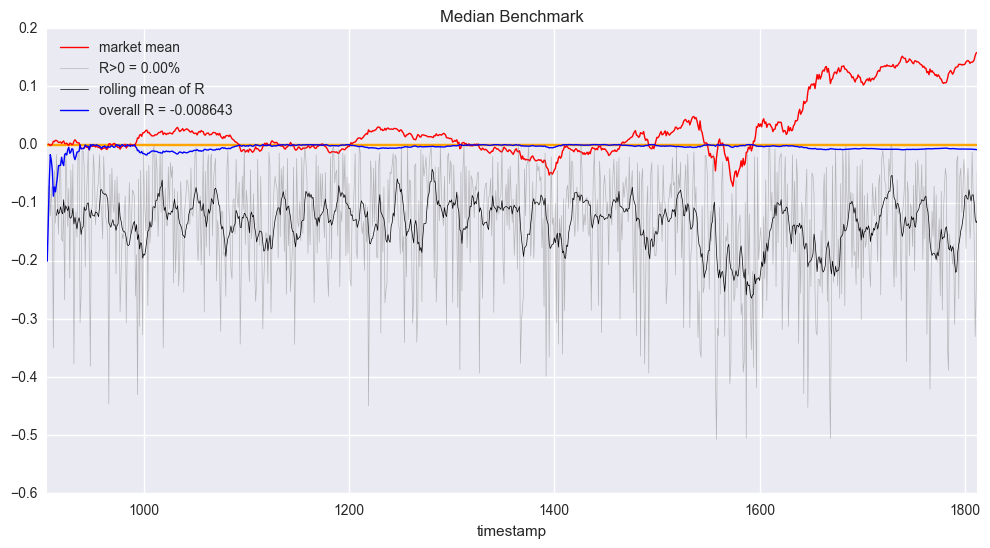

In [48]:
median_bench.plot()

## Mean of the trailing N days Benchmark (90 days)

In [44]:
# t-1 to t-90 Mean Benchmark
#
env = kagglegym.make()
obs = env.reset()
train_df = obs.train

n_days = 90
df_y = obs.train[['id','timestamp','y']]
mean_n = train_df.loc[train_df.timestamp > train_df.timestamp.max()-n_days].y.mean()

mean_90 = Performance('Mean of trailing 90 days')
done = False
while not done:
    ts = obs.features.timestamp[0]
    df_test = obs.features
    y_feature = df_test.technical_20 - df_test.technical_30
    df_test['y'] = y_feature
    df_y.append(df_test[['id','timestamp','y']])
    mean_n = df_y.loc[train_df.timestamp > train_df.timestamp.max()-n_days].y.mean()

    obs.target.y = mean_n
    target = obs.target
    obs, reward, done, info = env.step(obs.target)
    mean_90.update(ts, target.y, reward)
    
    if not ts % 100:
        print(ts,reward)
        
print(info)

1000 -0.00384060407649
1100 -0.0652611814439
1200 -0.0840088980863
1300 -0.0522532437938
1400 -0.158953272836
1500 -0.156678236156
1600 -0.177957572379
1700 -0.0138765264454
1800 -0.0422824042253
{'public_score': -0.0027603149162858955}


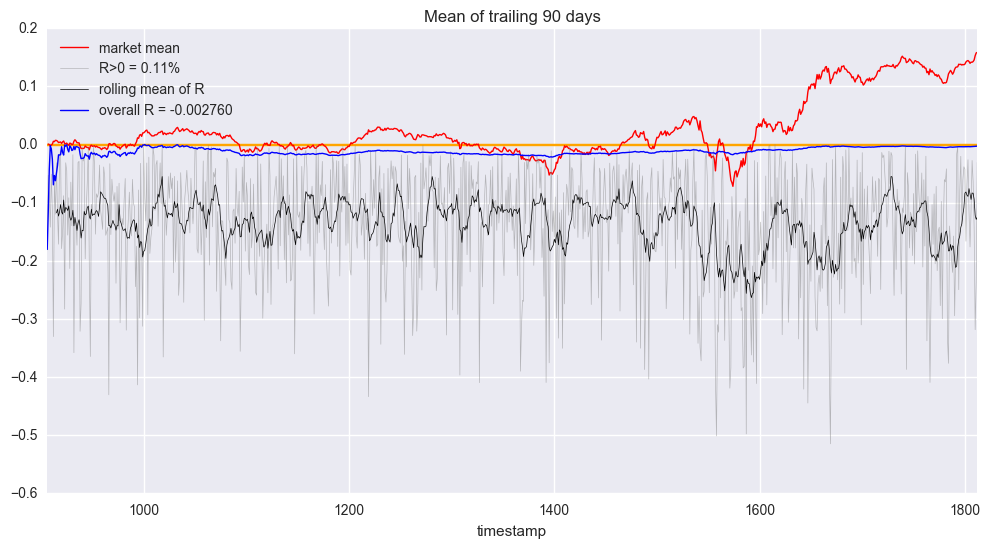

In [47]:
mean_90.plot()

## Mean per stock Benchmark

In [51]:
# Mean per stock Benchmark
# Inpute the market mean if we have not seen the stock before
#
env = kagglegym.make()
obs = env.reset()

mean_all = obs.train.y.mean()
mean_y = obs.train.groupby('id').y.mean()
mean_id = Performance('Mean per stock Benchmark')
done = False
while not done:
    ts = obs.features.timestamp[0]
    obs.target.y = mean_all
    obs.target.set_index('id', inplace=True)
    obs.target.update(mean_y)
    obs.target = obs.target.reset_index()
    target = obs.target
    obs, reward, done, info = env.step(obs.target)
    mean_id.update(ts, target.y, reward)
    if not ts % 100:
        print(ts,reward)
        
print(info)

1000 -0.118794943243
1100 -0.0973507187675
1200 -0.11406762107
1300 -0.0935677430942
1400 -0.175376721007
1500 -0.170207994831
1600 -0.17434756384
1700 -0.0587369628555
1800 -0.00360718472483
{'public_score': -0.03542191100943097}


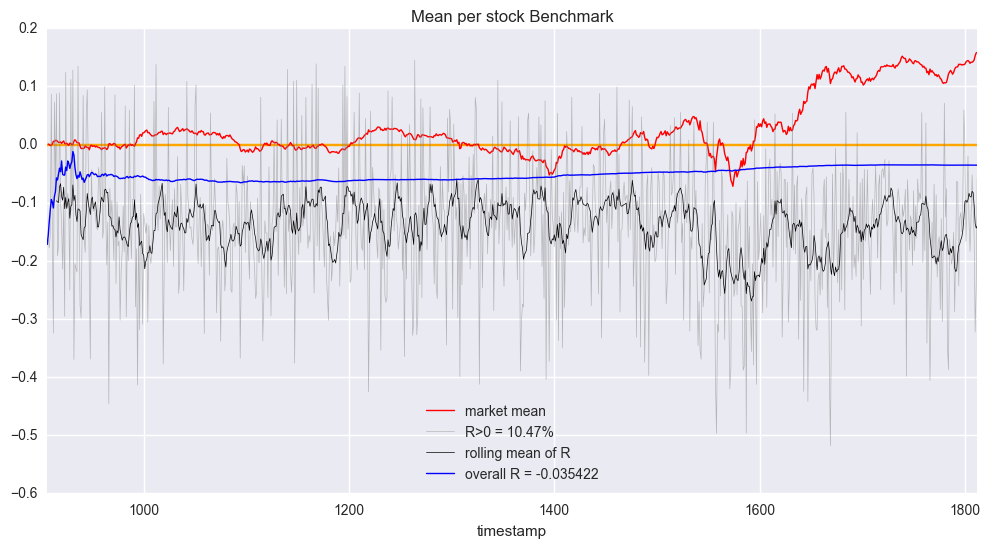

In [52]:
mean_id.plot()

## Ridge
- https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/
- https://www.kaggle.com/sudalairajkumar/two-sigma-financial-modeling/am-i-over-fitting

In [49]:
# full_train = pd.HDFStore("../input/train.h5", "r").get("train")

In [59]:
### https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659/run/545100
from sklearn.linear_model import Ridge

env = kagglegym.make()
observation = env.reset()

train = observation.train
mean_values = train.mean(axis=0)
train.fillna(mean_values, inplace=True)

# cols_to_use = ['technical_30', 'technical_20', 'fundamental_11']

# Observed with histograns:
low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)

ridge1 = Ridge() ## f11 only
ridge2 = Ridge() ## t30 and f11
ridge3 = Ridge() ## t20 and f11
ridge4 = Ridge() ## t30, t20, f11

train = train.loc[y_is_within_cut]

index1 = train.query("technical_30 == 0.0 & technical_20 == 0.0").index
index2 = train.query("technical_30 != 0.0 & technical_20 == 0.0").index
index3 = train.query("technical_30 == 0.0 & technical_20 != 0.0").index
index4 = train.query("technical_30 != 0.0 & technical_20 != 0.0").index

ridge1.fit(train.loc[index1, ["fundamental_11"]].values, train.loc[index1].y)
ridge2.fit(train.loc[index2, ['technical_30', 'fundamental_11']].values, train.loc[index2].y)
ridge3.fit(train.loc[index3, ['technical_20', 'fundamental_11']].values, train.loc[index3].y)
ridge4.fit(train.loc[index4, ['technical_30', 'technical_20', 'fundamental_11']].values, train.loc[index4].y)

# model = Ridge()
# model.fit(np.array(train.loc[y_is_within_cut, cols_to_use].values), train.loc[y_is_within_cut, target])


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [60]:
# ymean_dict = dict(train.groupby(["id"])["y"].mean())
ymedian_dict = dict(train.groupby(["id"])["y"].median())

def get_weighted_y(series):
    id, y = series["id"], series["y"]
    # return 0.95 * y + 0.05 * ymean_dict[id] if id in ymean_dict else y
    return 0.95 * y + 0.05 * ymedian_dict[id] if id in ymedian_dict else y

ridge_bench = Performance('Ridge')
done = False
while not done:
    ts = observation.features["timestamp"][0]
    observation.features.fillna(mean_values, inplace=True)
    # test_x = np.array(observation.features[cols_to_use].values)
    # observation.target.y = model.predict(test_x).clip(low_y_cut, high_y_cut)
    
    index1 = observation.features.query("technical_30 == 0.0 & technical_20 == 0.0").index
    index2 = observation.features.query("technical_30 != 0.0 & technical_20 == 0.0").index
    index3 = observation.features.query("technical_30 == 0.0 & technical_20 != 0.0").index
    index4 = observation.features.query("technical_30 != 0.0 & technical_20 != 0.0").index
    
    if len(index1) > 0:
        observation.target.loc[index1, 'y'] = ridge1.predict(observation.features.loc[index1, ["fundamental_11"]].values).clip(low_y_cut, high_y_cut)
    if len(index2) > 0:
        observation.target.loc[index2, 'y'] = ridge2.predict(observation.features.loc[index2, ['technical_30', 'fundamental_11']].values).clip(low_y_cut, high_y_cut)
    if len(index3) > 0:
        observation.target.loc[index3, 'y'] = ridge3.predict(observation.features.loc[index3, ['technical_20', 'fundamental_11']].values).clip(low_y_cut, high_y_cut)
    if len(index4) > 0:
        observation.target.loc[index4, 'y'] = ridge4.predict(observation.features.loc[index4, ['technical_30', 'technical_20', 'fundamental_11']].values).clip(low_y_cut, high_y_cut)

    ## weighted y using average value
    observation.target.y = observation.target.apply(get_weighted_y, axis = 1)
    
    target = observation.target
    observation, reward, done, info = env.step(target)
    ridge_bench.update(ts, target.y, reward)
    
    if ts % 100 == 0:
        print(ts,reward)
    
print(info)

1000 0.0599324130916
1100 -0.0159004462179
1200 -0.0850558114287
1300 -0.0837560873089
1400 -0.164944470658
1500 -0.146998786807
1600 -0.153866634939
1700 -0.0251157992891
1800 -0.066800755383
{'public_score': 0.020538039383154977}


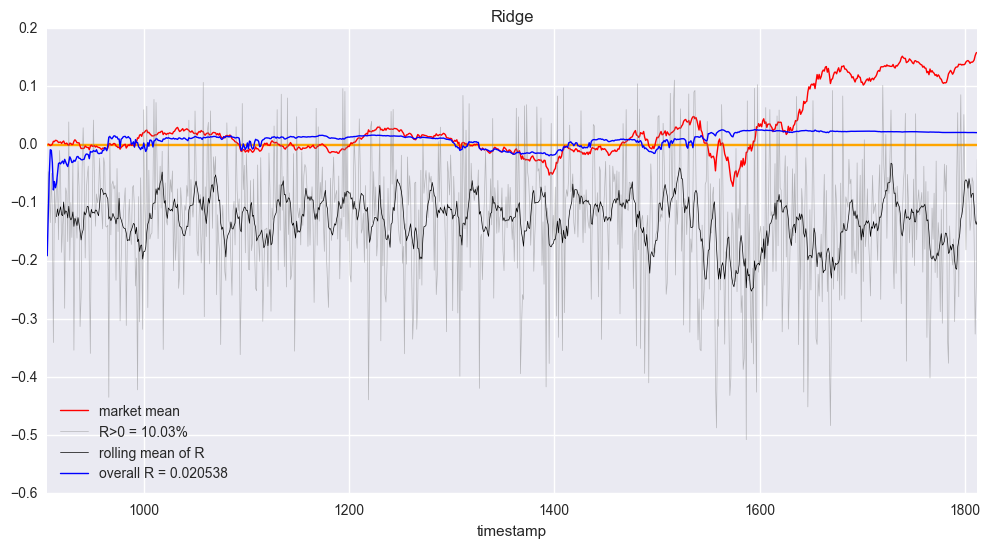

In [61]:
ridge_bench.plot()

## Done!